In [1]:
# imports

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from barnacle import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import statsmodels.api as sm
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mpl.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF', '#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
# custom continuous cmap 
grad_hexes = ['#9B5DE5', '#FFAC69']
grad_cmap = get_continuous_cmap(grad_hexes)

# keywargs for annotating panels
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}


# Collect data

In [4]:
# look at data

data_dir = Path('../../data/1-simulation/')
out_dir = Path('../../figures/1-simulation/')
results_df = pd.read_csv(data_dir / 'cv_data.csv')

results_df


,simulation_id,simulation_rank,simulation_shape,simulation_densities,simulation_mean_gene_sparsity,noise_level,rank,lambda,modeled_replicate,comparison_replicate,...,true_fms,model_factor0_cosine_similarity,true_factor0_cosine_similarity,model_factor0_support_cosine_similarity,true_factor0_support_cosine_similarity,recovery,relevance,precision,recall,f1
0,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,A,...,0.968004,NaN,0.975975,NaN,0.863145,0.745020,0.733815,0.996628,0.270695,0.425752
1,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,B,...,NaN,0.998289,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,C,...,NaN,0.998616,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,B,...,0.969436,NaN,0.976839,NaN,0.863145,0.745020,0.733815,0.996628,0.270695,0.425752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107995,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,B,B,...,0.038307,NaN,0.079064,NaN,0.050306,0.001616,0.003607,1.000000,0.000002,0.000003
107996,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,B,C,...,NaN,0.108747,NaN,0.131446,NaN,NaN,NaN,NaN,NaN,NaN
107997,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,C,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107998,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,C,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# separate out a dataframe of summary simulation information

# pull out simulation information
simulation_info_df = results_df[
    [
        'simulation_id', 
        'simulation_rank', 
        'simulation_shape', 
        'simulation_densities', 
        'simulation_mean_gene_sparsity', 
        'noise_level'
    ]
].drop_duplicates().reset_index(drop=True)
# separate out shape densities
simulation_info_df['mode0_length'] = [int(i[0]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
simulation_info_df['mode1_length'] = [int(i[1]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
simulation_info_df['mode2_length'] = [int(i[2]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
# separate out factor densities
simulation_info_df['factor0_density'] = [float(i[0]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df['factor1_density'] = [float(i[1]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df['factor2_density'] = [float(i[2]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df.drop(columns='simulation_densities', inplace=True)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,0.172216
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,0.785242
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,0.629525
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,0.445537
...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,0.688076
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,0.054712
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,0.222218


In [6]:
# separate out ground truth data 
# compares models against simulation ground truth

gt_df = results_df[results_df['modeled_replicate'] == results_df['comparison_replicate']]
gt_df = gt_df[[
    'simulation_id', 'rank', 'lambda', 'modeled_replicate', 'n_components', 'mean_gene_sparsity', 'relative_sse', 
    'true_fms', 'recovery', 'relevance', 'precision', 'recall', 'f1'
]].reset_index(drop=True)

# generate separate dataframe for aggregated metrics
gt_df_agg = gt_df.groupby([
    'simulation_id', 
    'rank', 
    'lambda'
]).agg(
    gt_sse_mean=('relative_sse', 'mean'), 
    gt_fms_mean=('true_fms', 'mean'), 
    gt_recovery_mean=('recovery', 'mean'), 
    gt_relevance_mean=('relevance', 'mean'), 
    gt_precision_mean=('precision', 'mean'), 
    gt_recall_mean=('recall', 'mean'), 
    gt_f1_mean=('f1', 'mean')
).reset_index()

gt_df_agg


,simulation_id,rank,lambda,gt_sse_mean,gt_fms_mean,gt_recovery_mean,gt_relevance_mean,gt_precision_mean,gt_recall_mean,gt_f1_mean
0,0,1,0.00,0.735902,0.968715,0.745020,0.733815,0.996628,0.270695,0.425752
1,0,1,0.05,0.735983,0.969580,0.755833,0.721098,0.997566,0.239136,0.385780
2,0,1,0.10,0.736223,0.970275,0.761934,0.709889,0.998171,0.219048,0.359250
3,0,1,0.20,0.737146,0.971413,0.775019,0.688210,0.998332,0.192987,0.323447
4,0,1,0.40,0.740527,0.971772,0.784032,0.645270,0.998758,0.150848,0.262096
...,...,...,...,...,...,...,...,...,...,...
11995,99,12,0.80,0.956957,0.699060,0.694540,0.755766,0.382136,0.998087,0.552380
11996,99,12,1.60,0.962084,0.607515,0.568776,0.639916,0.740125,0.896608,0.810805
11997,99,12,3.20,0.971799,0.479635,0.329393,0.376198,0.983599,0.336847,0.501805
11998,99,12,6.40,0.986087,0.252069,0.105295,0.160258,0.999274,0.036973,0.071283


In [7]:
# separate out cross validation data
# compares each model fit to one replicate against models fit to the other two replicates

cv_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
cv_df = cv_df[[
    'simulation_id', 'rank', 'lambda', 'modeled_replicate', 'comparison_replicate', 
    'replicate_pair', 'n_components', 'mean_gene_sparsity', 'relative_sse', 'model_fms'
]].reset_index(drop=True)

# generate separate dataframe for aggregated metrics
cv_df_agg = cv_df.groupby([
    'simulation_id', 
    'rank', 
    'lambda'
]).agg(
    cv_sse_mean=('relative_sse', 'mean'), 
    cv_sse_sem=('relative_sse', 'sem'), 
    cv_fms_mean=('model_fms', 'mean'), 
    cv_fms_sem=('model_fms', 'sem'), 
).reset_index()

cv_df_agg


,simulation_id,rank,lambda,cv_sse_mean,cv_sse_sem,cv_fms_mean,cv_fms_sem
0,0,1,0.00,0.736796,0.000476,0.998302,0.000103
1,0,1,0.05,0.736865,0.000467,0.998294,0.000105
2,0,1,0.10,0.737091,0.000457,0.998281,0.000105
3,0,1,0.20,0.737984,0.000438,0.998254,0.000103
4,0,1,0.40,0.741322,0.000401,0.998122,0.000111
...,...,...,...,...,...,...,...
11995,99,12,0.80,0.999732,0.000275,0.191187,0.005898
11996,99,12,1.60,0.994646,0.000181,0.178340,0.007997
11997,99,12,3.20,0.991113,0.000125,0.173118,0.005500
11998,99,12,6.40,0.994497,0.000118,0.114000,0.009856


# Estimating optimal sparsity

Unlike the R parameter which is used both in generating simulations and fitting models to data, the lambda parameter is not used to generate simulations and is only used to parameterize model fitting. Therefore there is no ground truth optimal lambda encoded in the simulated data.

Instread, ground truth optimal sparsity must be estimated. Here we estimate ground truth lambda by looking at cluster membership metrics, comparing the subset of models fit with the correct number of components against the simulation ground truth. The lambda corresponding to the maximum F1 score is used as the estimated ground truth optimal sparsity


In [8]:
# estimate ground truth optimal lambda based on F1 score

# set up dataframe for selecting best lambda
gt_lambda_df = gt_df_agg.copy()
gt_lambda_df['simulation_rank'] = gt_lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['simulation_rank']
)
# down-select to only models that were fit with the true number of components
gt_lambda_df = gt_lambda_df[gt_lambda_df['rank'] == gt_lambda_df['simulation_rank']].reset_index(drop=True)
# sort by descending lambda value so that if there is a tie in the score, the highest lambda value is picked
gt_lambda_df = gt_lambda_df.sort_values(['simulation_id', 'lambda'], ascending=False)

# identify the lambda corresponding to the max F1 score
gt_lambda_df = gt_lambda_df.loc[gt_lambda_df.groupby('simulation_id')['gt_f1_mean'].idxmax(), :].reset_index()

# add estimated ground truth optimal lambda to simulation info df
simulation_info_df['gt_lambda'] = simulation_info_df['simulation_id'].map(
    gt_lambda_df.set_index('simulation_id')['lambda']
)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,gt_lambda
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101,0.1
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,0.172216,0.2
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,0.785242,0.8
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,0.629525,0.8
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,0.445537,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075,0.0
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,0.688076,3.2
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,0.054712,0.8
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,0.222218,0.1


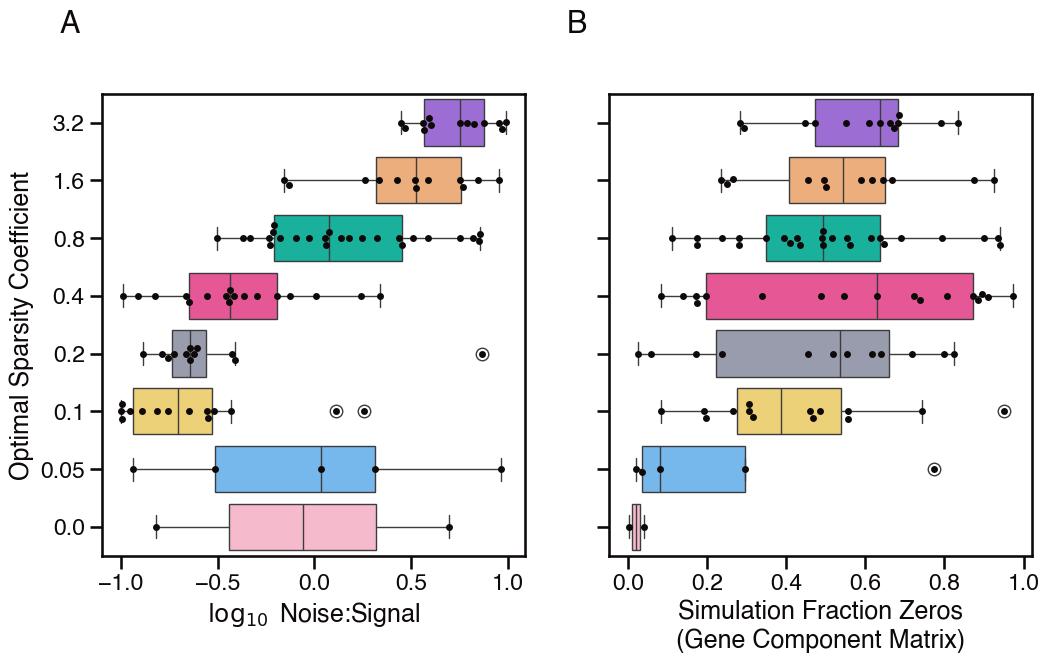

In [9]:
# plot optimal lambda by noise and simulation zeros

# curate data
plot_df = simulation_info_df
plot_df['true_sparsity'] = (1 - plot_df['factor0_density'])
plot_df['log_noise'] = np.log10(plot_df['noise_level'])

# plot figure
fig, axis = plt.subplots(1, 2, figsize=[12, 6], sharey=True)
for i, var in enumerate(['log_noise', 'true_sparsity']):
    sns.boxplot(
        x=var, 
        y='gt_lambda', 
        data=plot_df, 
        ax=axis[i], 
        palette=[accent_colors[i] for i in [0, 1, 2, 3, 5, 6, 7, 8]], 
        orient='h', 
        order = np.flip(np.sort(plot_df.gt_lambda.unique()))
    )
    sns.swarmplot(
        x=var, 
        y='gt_lambda', 
        data=plot_df, 
        ax=axis[i], 
        color=accent_colors[4], 
        orient='h', 
        order = np.flip(np.sort(plot_df.gt_lambda.unique()))
    )
    axis[i].annotate({0: 'A', 1: 'B'}[i], xy=(-0.1, 1.15), **annot_kwgs)
    axis[i].set_xlabel({
        'log_noise': '$\log_{10}$ Noise:Signal', 
        'true_sparsity': 'Simulation Fraction Zeros\n(Gene Component Matrix)'
    }[var])
    if not i:
        axis[i].set_ylabel('Optimal Sparsity Coefficient')
    
# plt.subplots_adjust(wspace=0.3)
plt.savefig(out_dir / 'estimating-optimal-lambda.png', bbox_inches='tight')


# Summarizing Accuracy of Optimal Models

Summary of simulated data experiments

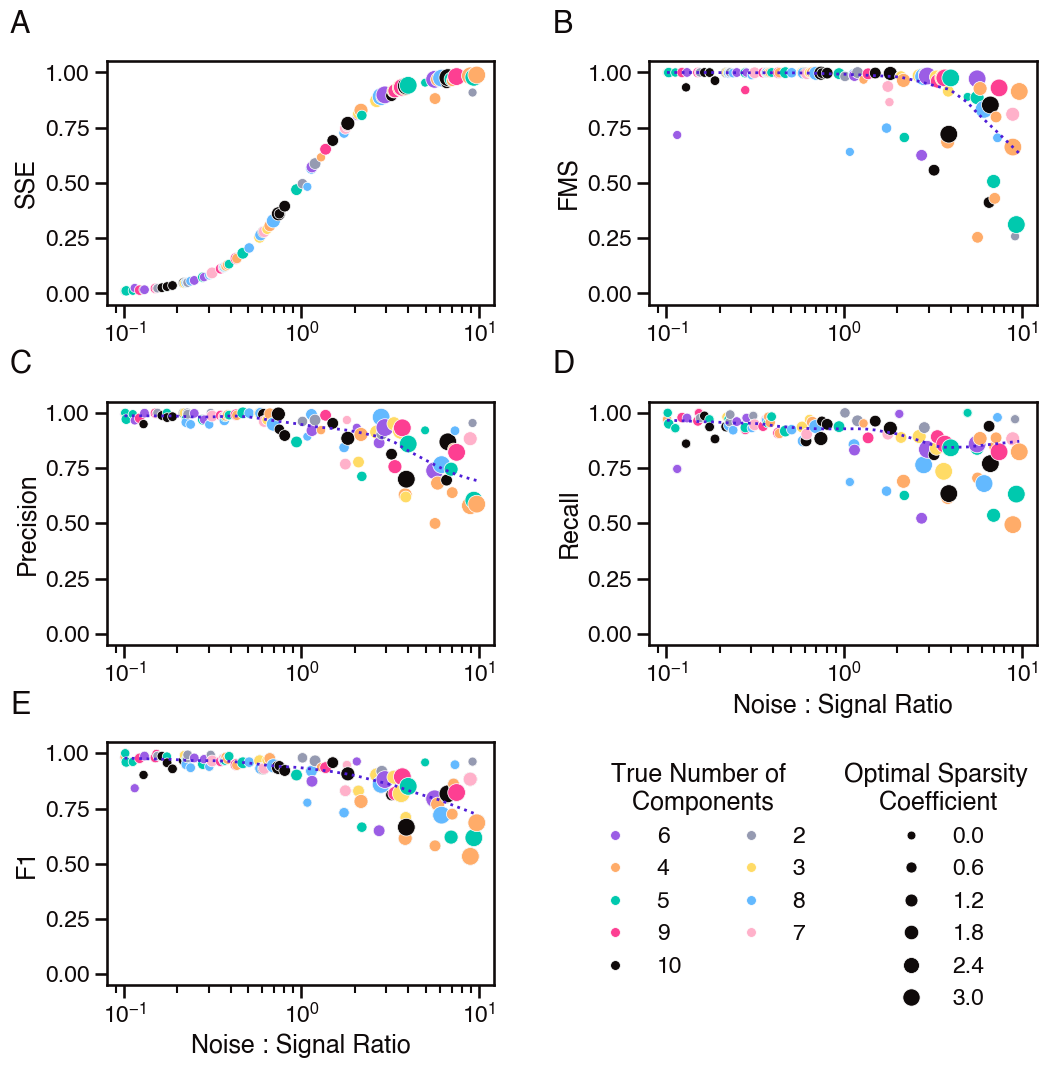

In [10]:
# plot metric differences of models parameterized with best fit and optimal lambda values

# make figure panel
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(3, 2, figure=fig, hspace=0.4, wspace=0.4)

# set up data
plot_df = pd.merge(
    simulation_info_df, 
    gt_df_agg, 
    left_on=['simulation_id', 'simulation_rank', 'gt_lambda'], 
    right_on=['simulation_id', 'rank', 'lambda'], 
    how='left'
)

# fix rank labels
plot_df['components'] = plot_df['simulation_rank'].astype('str')
plot_df = plot_df.sort_values('noise_level')

# set metric labels
labels = {
    'gt_sse_mean': 'SSE', 
    'gt_fms_mean': 'FMS', 
    'gt_precision_mean': 'Precision', 
    'gt_recall_mean': 'Recall', 
    'gt_f1_mean': 'F1', 
}

# plot data for each metric
for i, metric in enumerate(labels.keys()):
    # make new axis
    axis = fig.add_subplot(gs[(i // 2), (i % 2)])
    axis.annotate({0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}[i], xy=(-0.25, 1.15), **annot_kwgs)
    # make legends
    if i == 3:
        sns.scatterplot(x='noise_level', y=metric, hue='components', s=50, data=plot_df, ax=axis, legend=True)
        axis.legend(title='True Number of\n   Components', loc='upper left', ncol=2, bbox_to_anchor=(-0.2, -0.4))
    if i == 4:
        sns.scatterplot(x='noise_level', y=metric, size='gt_lambda', color=accent_colors[4], data=plot_df, ax=axis, legend=True)
        axis.legend(title='Optimal Sparsity\n     Coefficient', loc='upper left', bbox_to_anchor=(1.85, 1))
    # plot data
    sns.scatterplot(
        x='noise_level', y=metric, hue='components', size='gt_lambda', data=plot_df, ax=axis, legend=False
    )
    # plot LOWESS smoothed line
    if i:
        smoothed_line = sm.nonparametric.lowess(plot_df[metric], plot_df['log_noise'], frac = 0.3)
        sns.lineplot(x=plot_df['noise_level'], y=smoothed_line[:, 1], color=accent_colors[9], linestyle=':', legend=False)
    # fix labels
    if i > 2:
        axis.set(ylabel=labels[metric], xlabel='Noise : Signal Ratio', xscale='log', ylim=[-0.05, 1.05])
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log', ylim=[-0.05, 1.05])

plt.savefig(out_dir / 'simulation-optimal-model-summary.png', bbox_inches='tight')


In [11]:
# look at statistics of optimal models

plot_df.describe()

,simulation_id,simulation_rank,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,...,log_noise,rank,lambda,gt_sse_mean,gt_fms_mean,gt_recovery_mean,gt_relevance_mean,gt_precision_mean,gt_recall_mean,gt_f1_mean
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,6.220000,289.676088,2.190888,542.190000,50.890000,55.640000,0.509863,0.551759,0.519539,...,-0.030240,6.220000,0.916500,0.473796,0.908683,0.870260,0.860762,0.905588,0.883681,0.891024
std,29.011492,2.572504,234.802607,2.647171,293.955047,26.039944,25.675331,0.263503,0.255004,0.282503,...,0.611895,2.572504,1.000986,0.390236,0.172698,0.135475,0.145532,0.119463,0.115264,0.110515
min,0.000000,2.000000,5.093007,0.100814,41.000000,10.000000,10.000000,0.026889,0.026430,0.011921,...,-0.996478,2.000000,0.000000,0.010290,0.254236,0.425982,0.434237,0.499758,0.494311,0.533640
25%,24.750000,4.000000,83.487368,0.278132,266.250000,26.750000,33.000000,0.325250,0.346008,0.304022,...,-0.555749,4.000000,0.200000,0.073730,0.918686,0.791266,0.774009,0.868811,0.844926,0.830178
50%,49.500000,6.000000,220.984717,0.777711,563.000000,52.000000,60.500000,0.505111,0.560903,0.493047,...,-0.109442,6.000000,0.600000,0.377948,0.994330,0.930903,0.928343,0.959169,0.929183,0.937927
75%,74.250000,8.250000,446.913818,3.326509,785.000000,74.500000,78.000000,0.722822,0.765765,0.721259,...,0.521982,8.250000,1.000000,0.901201,0.999403,0.968358,0.966850,0.990206,0.963432,0.966825
max,99.000000,10.000000,901.747505,9.701963,1000.000000,98.000000,98.000000,0.997828,0.952523,0.994258,...,0.986860,10.000000,3.200000,0.988433,0.999980,1.000000,1.000000,1.000000,1.000000,1.000000


# Parameter Selection via Cross Validation

## Selecting model rank

In model fitting, model rank is selected as the rank of the model with the minimum cross-validated SSE value

In [12]:
# find the optimal rank parameter for each simulation based on minimum CV SSE

rank_optima_df = cv_df.copy()
# select the sse minimum for each simulation
rank_optima_df = rank_optima_df.loc[rank_optima_df.groupby('simulation_id').relative_sse.idxmin(), :]
# map selected rank back to simulation_info_df
rank_optima = rank_optima_df.set_index('simulation_id')['rank']
simulation_info_df['selected_rank'] = simulation_info_df['simulation_id'].map(rank_optima)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,gt_lambda,true_sparsity,log_noise,selected_rank
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101,0.1,0.266182,-0.519240,8
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,0.172216,0.2,0.617592,-0.624195,8
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,0.785242,0.8,0.636897,0.587226,3
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,0.629525,0.8,0.553534,-0.178434,4
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,0.445537,1.6,0.496828,0.766355,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075,0.0,0.002172,-0.816981,9
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,0.688076,3.2,0.672147,0.970298,1
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,0.054712,0.8,0.490676,0.507049,7
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,0.222218,0.1,0.317392,-0.649595,5


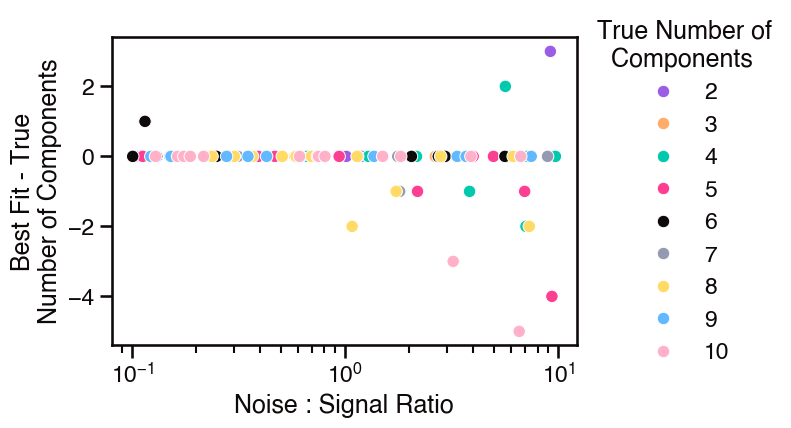

In [13]:
# plot true rank vs. optimal rank

# arrange data for plotting
rank_plot_df = simulation_info_df.copy()
rank_plot_df['min_cv_sse'] = rank_plot_df['simulation_id'].map(
    rank_optima_df.set_index('simulation_id')['relative_sse']
)
rank_plot_df['rank_difference'] = rank_plot_df['selected_rank'] - rank_plot_df['simulation_rank']
rank_plot_df = rank_plot_df.sort_values(['simulation_rank', 'noise_level']).reset_index(drop=True)
rank_plot_df['simulation_rank'] = rank_plot_df['simulation_rank'].astype(str)

# create plot
fig_1a, ax_1a = plt.subplots(figsize=[6, 4])
sns.scatterplot(
    x='noise_level', 
    y='rank_difference', 
    hue='simulation_rank', 
    alpha=1.0, 
    data=rank_plot_df, 
    ax=ax_1a
)
plt.xlabel('Noise : Signal Ratio');
plt.ylabel('Best Fit - True\nNumber of Components');
plt.xscale('log')
plt.legend(title='True Number of\n  Components', loc='center left', bbox_to_anchor=[1, .5]);
# plt.savefig('optimal_rank_v_noise.png', bbox_inches='tight')


# Parameter Selection via Cross Validation

## Selecting model sparsity

In model fitting, the sparsity coefficient (lambda) is selected using the subset of models fit with the optimal rank, as determined by minimum SSE decribed above. From these models, the best fit lambda is selected as the maximum lambda for which the corresponding cross-validated FMS falls within 1 standard error of the maximum cross-validated FMS.


In [14]:
# find the optimal rank parameter for each simulation based on minimum CV SSE

lambda_optima_df = cv_df.copy()
# down-select to just the best fit rank models for each simulation
lambda_optima_df['selected_rank'] = lambda_optima_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['selected_rank']
)
lambda_optima_df = lambda_optima_df[lambda_optima_df['rank'] == lambda_optima_df['selected_rank']]

# average scores across CV replicates
lambda_optima_df = lambda_optima_df.groupby(['simulation_id', 'rank', 'lambda']).agg(
    sse_mean=('relative_sse', 'mean'), 
    sse_sem=('relative_sse', 'sem'), 
    fms_mean=('model_fms', 'mean'), 
    fms_sem=('model_fms', 'sem'), 
    bootstraps=('relative_sse', 'count')
).reset_index()

# find max CV FMS for each simulation and calculate 1SE threshold
max_fms_df = lambda_optima_df.loc[lambda_optima_df.groupby('simulation_id').fms_mean.idxmax(), :]
max_fms_df['fms_threshold'] = max_fms_df['fms_mean'] - max_fms_df['fms_sem']
lambda_optima_df['fms_threshold'] = lambda_optima_df['simulation_id'].map(max_fms_df.set_index('simulation_id')['fms_threshold'])

# down-select to maximum lambda model with CV FMS above the 1SE threshold
lambda_optima_df = lambda_optima_df[lambda_optima_df.fms_mean.ge(lambda_optima_df['fms_threshold'])]
lambda_optima_df = lambda_optima_df.loc[lambda_optima_df.groupby('simulation_id')['lambda'].idxmax(), :].reset_index()

# map selected lambda back to simulation_info_df
lambda_optima = lambda_optima_df.set_index('simulation_id')['lambda']
simulation_info_df['selected_lambda'] = simulation_info_df['simulation_id'].map(lambda_optima)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,gt_lambda,true_sparsity,log_noise,selected_rank,selected_lambda
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101,0.1,0.266182,-0.519240,8,0.05
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,0.172216,0.2,0.617592,-0.624195,8,0.10
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,0.785242,0.8,0.636897,0.587226,3,0.80
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,0.629525,0.8,0.553534,-0.178434,4,0.80
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,0.445537,1.6,0.496828,0.766355,4,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075,0.0,0.002172,-0.816981,9,0.10
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,0.688076,3.2,0.672147,0.970298,1,1.60
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,0.054712,0.8,0.490676,0.507049,7,0.80
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,0.222218,0.1,0.317392,-0.649595,5,0.10


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


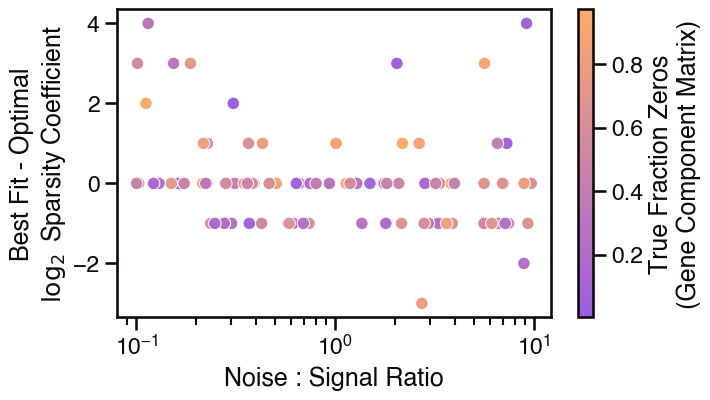

In [15]:
# plot true rank vs. optimal rank
# NOTE: 6 data points in which the optimal or selected lambda was 0 were removed for ease of plotting.

# arrange data for plotting
lambda_plot_df = simulation_info_df.copy()
lambda_plot_df['log_lambda_difference'] = np.log2(lambda_plot_df['selected_lambda']) - np.log2(lambda_plot_df['gt_lambda'])
# lambda_plot_df = lambda_plot_df.sort_values(['simulation_rank', 'noise_level']).reset_index(drop=True)
lambda_plot_df['true_sparsity'] = 1 - lambda_plot_df['factor0_density']

# create plot
fig_b, ax_b = plt.subplots(figsize=[7, 4])
sns.scatterplot(
    x='noise_level', 
    y='log_lambda_difference', 
    hue='true_sparsity', 
    palette=grad_cmap, 
    alpha=1.0, 
    data=lambda_plot_df, 
    ax=ax_b
)
plt.xlabel('Noise : Signal Ratio');
plt.ylabel('Best Fit - Optimal\n$\log_2$ Sparsity Coefficient');
plt.xscale('log')
# make a colorbar for the markers and replace the default legend with that
norm = plt.Normalize(lambda_plot_df['true_sparsity'].min(), lambda_plot_df['true_sparsity'].max())
sm = plt.cm.ScalarMappable(cmap=grad_cmap, norm=norm)
sm.set_array([])
ax_b.get_legend().remove()
ax_b.figure.colorbar(sm, ax=ax_b, label='True Fraction Zeros\n(Gene Component Matrix)');

# plt.savefig('optimal_rank_v_noise.png', bbox_inches='tight')


In [16]:
# look at simulations in which optimal lambda or selected lambda is zero

lambda_plot_df[abs(lambda_plot_df['log_lambda_difference']) == np.inf]


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,gt_lambda,true_sparsity,log_noise,selected_rank,selected_lambda,log_lambda_difference
17,17,8,"(127, 89, 13)",11.340027,1.736297,127,89,13,0.089292,0.068932,0.881714,0.40,0.910708,0.239624,7,0.0,-inf
59,59,8,"(938, 13, 84)",212.853830,1.079118,938,13,84,0.226923,0.795579,0.011921,0.05,0.773077,0.033069,6,0.0,-inf
77,77,5,"(465, 21, 39)",446.220759,4.965859,465,21,39,0.959615,0.492751,0.708791,0.00,0.040385,0.695994,5,0.2,inf
86,86,10,"(52, 68, 36)",13.323986,0.129075,52,68,36,0.256231,0.090550,0.890689,0.10,0.743769,-0.889159,10,0.0,-inf
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075,0.00,0.002172,-0.816981,9,0.1,inf


# Parameter selection workflow validation figure

Main text figure to show the results of testing the parameter gridsearch workflow using 100 simulated data tensors


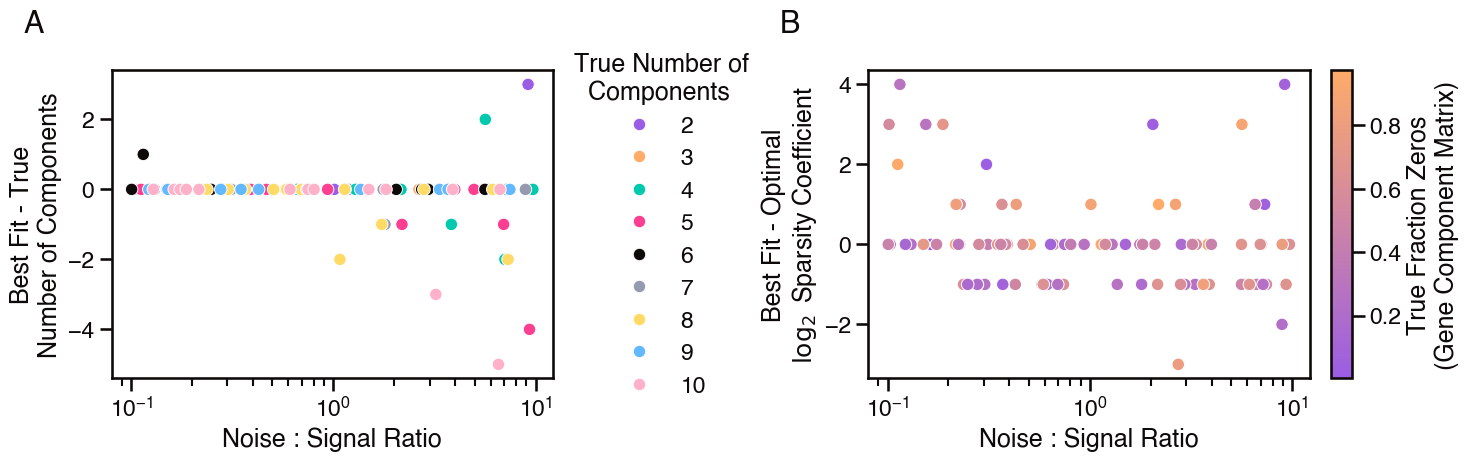

In [17]:
# plot metric differences of models parameterized with best fit and optimal lambda values

# make figure panel
fig = plt.figure(figsize=(16, 4))
gs = plt.GridSpec(1, 30, wspace=1, figure=fig)

# plot true rank vs. optimal rank
ax_a = fig.add_subplot(gs[0, 0:11])
ax_a.annotate('A', xy=(-0.2, 1.15), **annot_kwgs)
sns.scatterplot(
    x='noise_level', 
    y='rank_difference', 
    hue='simulation_rank', 
    alpha=1.0, 
    data=rank_plot_df, 
    ax=ax_a
)
ax_a.set(xlabel='Noise : Signal Ratio', ylabel='Best Fit - True\nNumber of Components', xscale='log')
ax_a.legend(title='True Number of\n  Components', loc='center left', bbox_to_anchor=[1, .5]);


# plot lambda validation
ax_b = fig.add_subplot(gs[0, 18:29])
ax_b.annotate('B', xy=(-0.2, 1.15), **annot_kwgs)
sns.scatterplot(
    x='noise_level', 
    y='log_lambda_difference', 
    hue='true_sparsity', 
    palette=grad_cmap, 
    alpha=1.0, 
    data=lambda_plot_df, 
    ax=ax_b
)
ax_b.set(xlabel='Noise : Signal Ratio', ylabel='Best Fit - Optimal\n$\log_2$ Sparsity Coefficient', xscale='log')
# make a colorbar for the markers and replace the default legend with that
norm = plt.Normalize(lambda_plot_df['true_sparsity'].min(), lambda_plot_df['true_sparsity'].max())
sm = plt.cm.ScalarMappable(cmap=grad_cmap, norm=norm)
sm.set_array([])
ax_b.get_legend().remove()
ax_b.figure.colorbar(sm, cax=fig.add_subplot(gs[0, 29]), 
                     label='True Fraction Zeros\n(Gene Component Matrix)', aspect=20);

plt.savefig(out_dir / 'cv-parameterization-validation.png', bbox_inches='tight')


In [18]:
# calculate stats

param_summary_df = lambda_plot_df.join(rank_plot_df.set_index('simulation_id')['rank_difference'], 
                                       on='simulation_id')

print('Correct rank parameter:')
print(param_summary_df['rank_difference'].eq(0).value_counts())

print('Rank off by one or less:')
print(np.abs(param_summary_df['rank_difference']).le(1).value_counts())

print('Correct lambda parameter:')
print(param_summary_df['log_lambda_difference'].eq(0).value_counts())

print('Lambda parameter off by power of 2 or less:')
print(np.abs(param_summary_df['log_lambda_difference']).le(1).value_counts())

print('Both rank and lambda match:')
print((param_summary_df['rank_difference'].eq(0) & 
       param_summary_df['log_lambda_difference'].eq(0)).value_counts())

print('Both rank and lambda within one unit:')
print((np.abs(param_summary_df['rank_difference']).le(1) & 
       np.abs(param_summary_df['log_lambda_difference']).le(1)).value_counts())

print('Simulations with noise:signal less than 1:')
print(param_summary_df['noise_level'].lt(1).value_counts())

print('Lambda undershoot:')
print(param_summary_df['log_lambda_difference'].lt(0).value_counts())

print('Lambda overshoot:')
print(param_summary_df['log_lambda_difference'].gt(0).value_counts())

print('Mean R miss above noise:signal of 1:')
r_misses = param_summary_df[~param_summary_df['rank_difference'].eq(0)]
print(np.abs(r_misses[r_misses['noise_level'].gt(1)]['rank_difference']).mean())

lamb_misses = param_summary_df[~param_summary_df['log_lambda_difference'].eq(0)]
lamb_misses = lamb_misses[~(lamb_misses.log_lambda_difference == np.inf)]
lamb_misses = lamb_misses[~(lamb_misses.log_lambda_difference == -np.inf)]
print('Mean lambda miss below noise:signal of 1:')
print(np.abs(lamb_misses[lamb_misses['noise_level'].lt(1)].log_lambda_difference).mean())
print('Mean lambda miss above noise:signal of 1:')
print(np.abs(lamb_misses[lamb_misses['noise_level'].gt(1)].log_lambda_difference).mean())


Correct rank parameter:
rank_difference
True     86
False    14
Name: count, dtype: int64
Rank off by one or less:
rank_difference
True     92
False     8
Name: count, dtype: int64
Correct lambda parameter:
log_lambda_difference
False    54
True     46
Name: count, dtype: int64
Lambda parameter off by power of 2 or less:
log_lambda_difference
True     80
False    20
Name: count, dtype: int64
Both rank and lambda match:
False    58
True     42
Name: count, dtype: int64
Both rank and lambda within one unit:
True     75
False    25
Name: count, dtype: int64
Simulations with noise:signal less than 1:
noise_level
True     52
False    48
Name: count, dtype: int64
Lambda undershoot:
log_lambda_difference
False    66
True     34
Name: count, dtype: int64
Lambda overshoot:
log_lambda_difference
False    80
True     20
Name: count, dtype: int64
Mean R miss above noise:signal of 1:
2.1538461538461537
Mean lambda miss below noise:signal of 1:
1.4782608695652173
Mean lambda miss above noise:signal 

# Robustness to mis-specification

## Rank

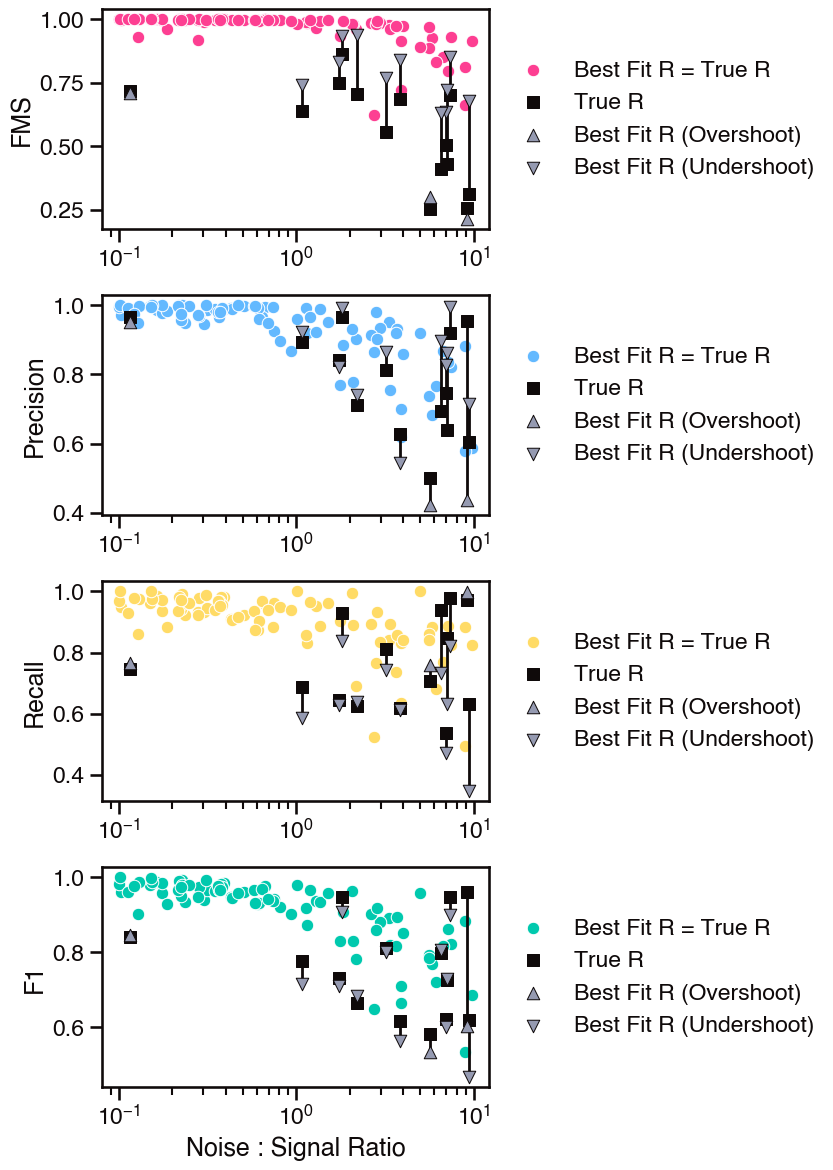

In [19]:
# compare scores of optimal and suboptimal rank values

# make figure panel
fig = plt.figure(figsize=(5, 14))
gs = plt.GridSpec(4, 1, figure=fig, hspace=.3)

# set up data
robust_rank_df = pd.concat([
    pd.merge(
        simulation_info_df, 
        gt_df_agg, 
        left_on=['simulation_id', 'simulation_rank', 'gt_lambda'], 
        right_on=['simulation_id', 'rank', 'lambda'], 
        how='left'
    ), 
    pd.merge(
        simulation_info_df, 
        gt_df_agg, 
        left_on=['simulation_id', 'selected_rank', 'gt_lambda'], 
        right_on=['simulation_id', 'rank', 'lambda'], 
        how='left'
    )
]).drop_duplicates().reset_index(drop=True)
robust_rank_df['comparison'] = 'match'
robust_rank_df.loc[
    (robust_rank_df['selected_rank'] < robust_rank_df['simulation_rank']), 'comparison'] = 'undershoot'
robust_rank_df.loc[
    (robust_rank_df['selected_rank'] > robust_rank_df['simulation_rank']), 'comparison'] = 'overshoot'

# set colors and labels
colors = {
    'gt_fms_mean': accent_colors[3], 
    'gt_precision_mean': accent_colors[7], 
    'gt_recall_mean': accent_colors[6], 
    'gt_f1_mean': accent_colors[2], 
}
labels = {
    'gt_fms_mean': 'FMS', 
    'gt_precision_mean': 'Precision', 
    'gt_recall_mean': 'Recall', 
    'gt_f1_mean': 'F1', 
}

# plot each metric
for i, metric in enumerate(labels.keys()):
    # make new axis
    axis = fig.add_subplot(gs[i, 0])
    # plot points where best fit matches true
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'match']
    data_df = data_df[data_df['rank'] == data_df['simulation_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='Best Fit R = True R', 
        data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit rank does not fit optimal rank
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['rank'] == data_df['simulation_rank']][metric], 
        data_df[data_df['rank'] == data_df['selected_rank']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of true rank where best fit rank doesn't match
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    data_df = data_df[data_df['rank'] == data_df['simulation_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='True R', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it overshoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['rank'] == data_df['selected_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='Best Fit R (Overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it undershoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['rank'] == data_df['selected_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='Best Fit R (Undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='Noise : Signal Ratio', xscale='log')
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log')
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


# Robustness to mis-specification

## Lambda    

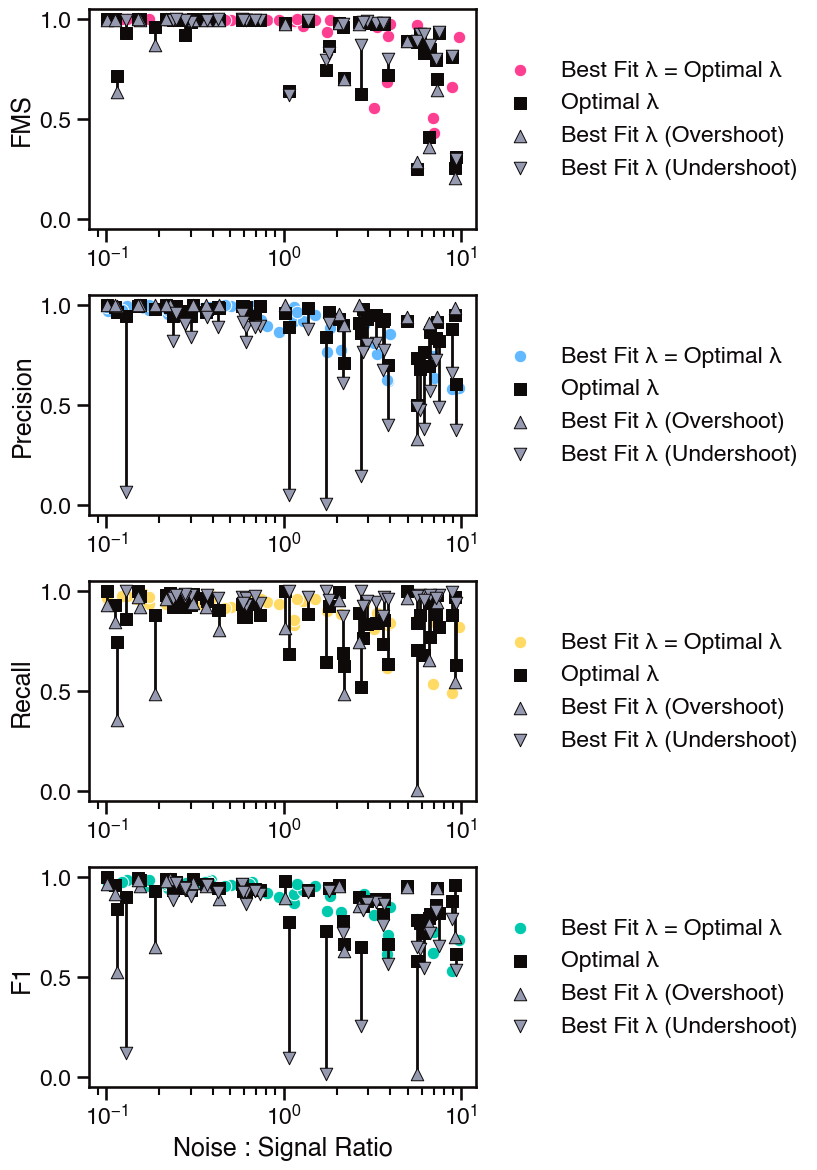

In [20]:
# plot metric differences of models parameterized with best fit and optimal lambda values

# make figure panel
fig = plt.figure(figsize=(5, 14))
gs = plt.GridSpec(4, 1, figure=fig, hspace=.3)

# set up data
robust_lambda_df = pd.concat([
    pd.merge(
        simulation_info_df, 
        gt_df_agg, 
        left_on=['simulation_id', 'simulation_rank', 'gt_lambda'], 
        right_on=['simulation_id', 'rank', 'lambda'], 
        how='left'
    ), 
    pd.merge(
        simulation_info_df, 
        gt_df_agg, 
        left_on=['simulation_id', 'simulation_rank', 'selected_lambda'], 
        right_on=['simulation_id', 'rank', 'lambda'], 
        how='left'
    )
]).drop_duplicates().reset_index(drop=True) 
robust_lambda_df['comparison'] = 'match'
robust_lambda_df.loc[
    (robust_lambda_df['selected_lambda'] > robust_lambda_df['gt_lambda']), 'comparison'] = 'overshoot'
robust_lambda_df.loc[
    (robust_lambda_df['selected_lambda'] < robust_lambda_df['gt_lambda']), 'comparison'] = 'undershoot'

# set colors and labels
colors = {
    'gt_fms_mean': accent_colors[3], 
    'gt_precision_mean': accent_colors[7], 
    'gt_recall_mean': accent_colors[6], 
    'gt_f1_mean': accent_colors[2], 
}
labels = {
    'gt_fms_mean': 'FMS', 
    'gt_precision_mean': 'Precision', 
    'gt_recall_mean': 'Recall', 
    'gt_f1_mean': 'F1', 
}

# plot each metric
for i, metric in enumerate(labels.keys()):
    # make new axis
    axis = fig.add_subplot(gs[i, 0])
    # plot points where best fit matches optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'match']
    data_df = data_df[data_df['lambda'] == data_df['gt_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='Best Fit λ = Optimal λ', data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit lambda does not fit optimal lambda
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['lambda'] == data_df['gt_lambda']][metric], 
        data_df[data_df['lambda'] == data_df['selected_lambda']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of optimal lambda where best fit lambda doesn't match
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    data_df = data_df[data_df['lambda'] == data_df['gt_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='Optimal λ', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it overshoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['lambda'] == data_df['selected_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='Best Fit λ (Overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it undershoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['lambda'] == data_df['selected_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='Best Fit λ (Undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='Noise : Signal Ratio', xscale='log', ylim=[-0.05, 1.05])
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log', ylim=[-0.05, 1.05])
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


# Robustness to mis-specification

## Combined Figure

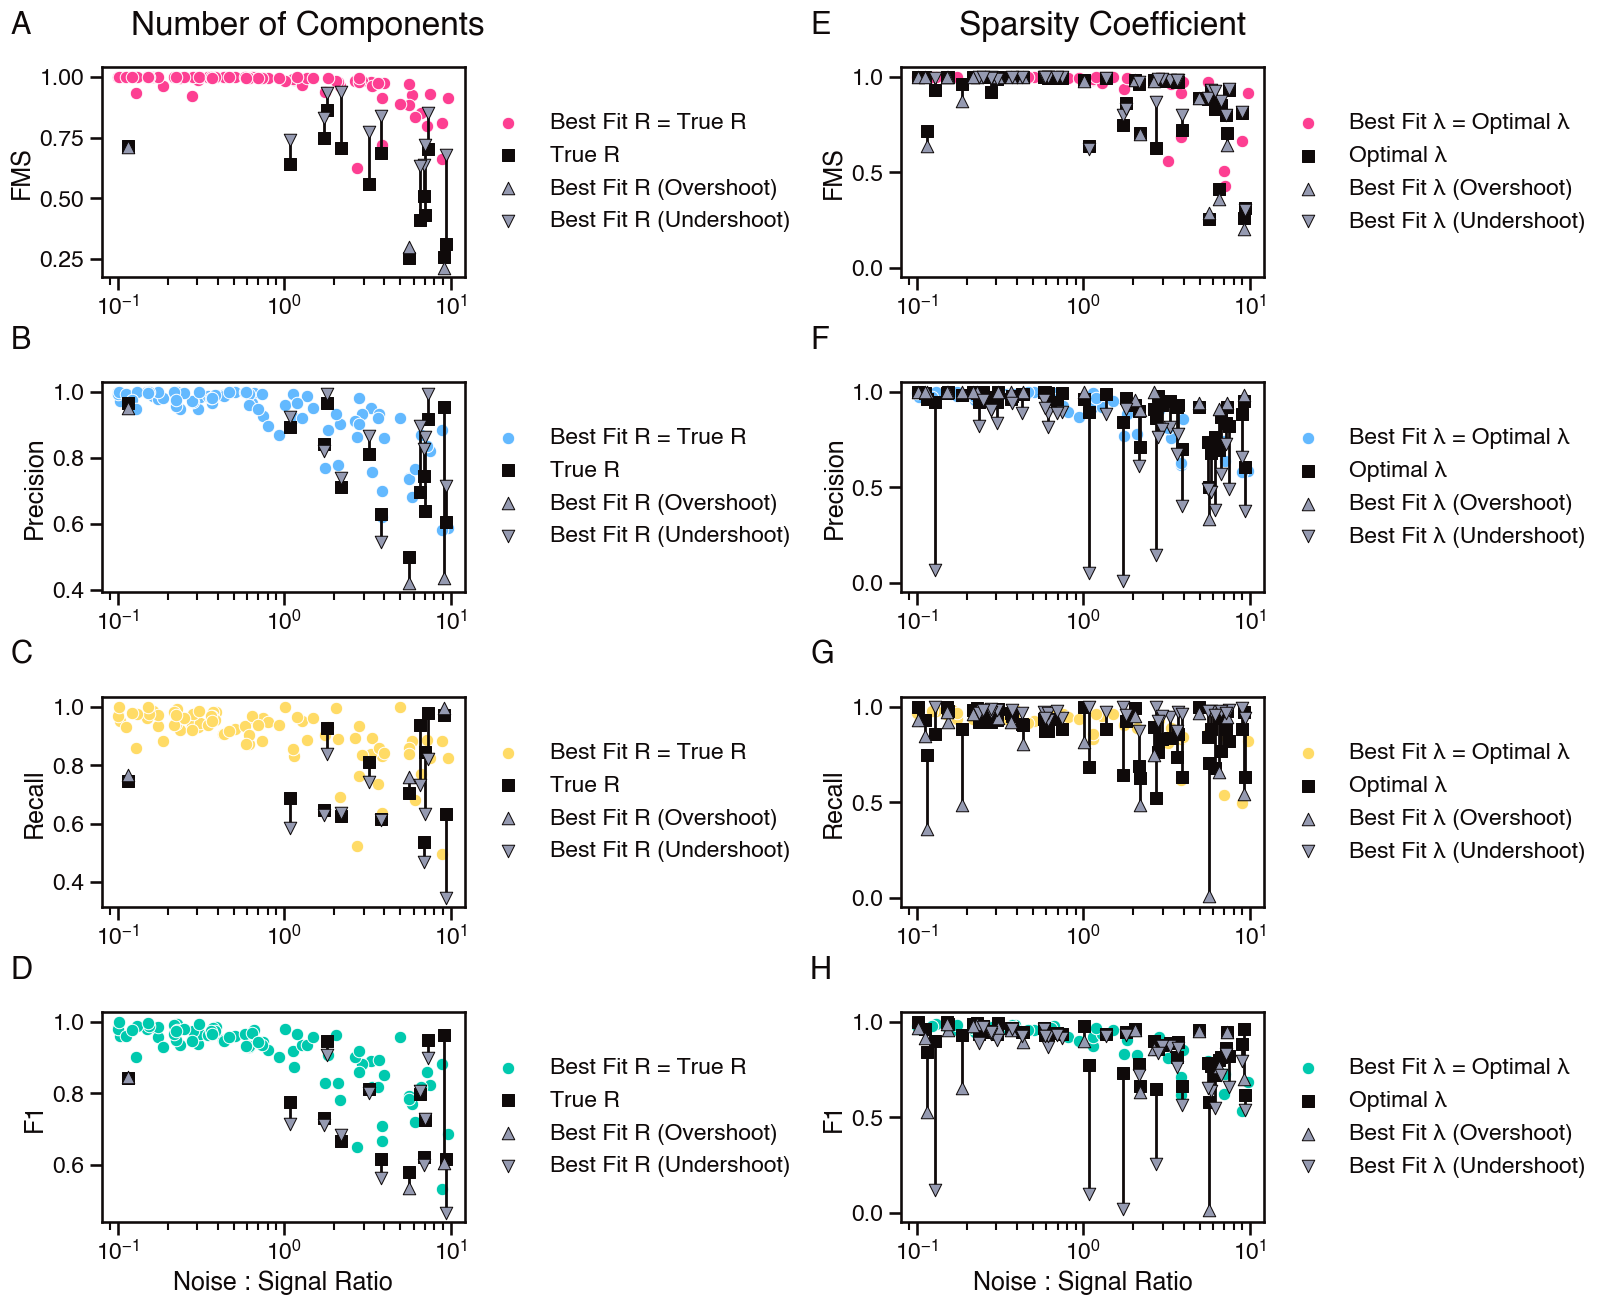

In [21]:
# panel figure: combine rank and lambda data

# make figure panel
fig = plt.figure(figsize=(15, 15))
gs = plt.GridSpec(4, 2, figure=fig, hspace=.5, wspace=1.2)

# rank robustness to misspecification
for i, metric in enumerate(labels.keys()):
    # make new axis
    axis = fig.add_subplot(gs[i, 0])
    axis.annotate({0: 'A', 1: 'B', 2: 'C', 3: 'D'}[i], xy=(-0.25, 1.2), **annot_kwgs)
    if not i:
        axis.annotate('Number of Components', xy=(0.08, 1.2), xycoords='axes fraction', va='center', ha='left',
                      fontsize=24, annotation_clip=False)
    # plot points where best fit matches true
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'match']
    data_df = data_df[data_df['rank'] == data_df['simulation_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='Best Fit R = True R', 
        data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit rank does not fit optimal rank
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['rank'] == data_df['simulation_rank']][metric], 
        data_df[data_df['rank'] == data_df['selected_rank']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of true rank where best fit rank doesn't match
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    data_df = data_df[data_df['rank'] == data_df['simulation_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='True R', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it overshoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['rank'] == data_df['selected_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='Best Fit R (Overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it undershoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['rank'] == data_df['selected_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='Best Fit R (Undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='Noise : Signal Ratio', xscale='log')
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log')
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# lambda robustness to misspecification
for i, metric in enumerate(labels.keys()):
    # make new axis
    axis = fig.add_subplot(gs[i, 1])
    axis.annotate({0: 'E', 1: 'F', 2: 'G', 3: 'H'}[i], xy=(-0.25, 1.2), **annot_kwgs)
    if not i:
        axis.annotate('Sparsity Coefficient', xy=(0.16, 1.2), xycoords='axes fraction', va='center', ha='left',
                      fontsize=24, annotation_clip=False)
    # plot points where best fit matches optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'match']
    data_df = data_df[data_df['lambda'] == data_df['gt_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='Best Fit λ = Optimal λ', data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit lambda does not fit optimal lambda
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['lambda'] == data_df['gt_lambda']][metric], 
        data_df[data_df['lambda'] == data_df['selected_lambda']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of optimal lambda where best fit lambda doesn't match
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    data_df = data_df[data_df['lambda'] == data_df['gt_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='Optimal λ', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it overshoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['lambda'] == data_df['selected_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='Best Fit λ (Overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it undershoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['lambda'] == data_df['selected_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='Best Fit λ (Undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='Noise : Signal Ratio', xscale='log', ylim=[-0.05, 1.05])
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log', ylim=[-0.05, 1.05])
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
fig.savefig(out_dir / 'robustness-to-misspecification.png', bbox_inches='tight')
